# Analysis of Bulbapedia - language confidence score

In [8]:
from os import path, remove

from config.run_modes import handle_auto_count

DICT_PATH = "../word-counts.json"

# generate a new word count dictionary for wiki
if path.exists(DICT_PATH):
    remove(DICT_PATH)

print("Downloading word counts. Please wait...")
handle_auto_count("Type", 100, 0.1)

## Confidence score

Mierzy zgodność rozkładu częstości słów z rozkładem referencyjnym języka. - miara pokrycia masy probabilistycznej języka referencyjnego przez tekst wiki, zadana wzzorem:

$$
\text{score} = 100 \times
\frac{\sum_{i} \min(\text{rel\_freq}_i, \text{wiki\_freq}_i)}
     {\sum_{i} \text{wiki\_freq}_i}
$$
gdzie:
- `wiki_freq` zadaje najczęstrze słowa w wiki
- `rel_freq` zadaje najczęstrzr słowa w języku

In [11]:
import pandas as pd


def lang_confidence_score(word_data: pd.DataFrame) -> float:
    """
    Oblicza procent dopasowania słów z tekstu do języka referencyjnego.

    word_data: pd.DataFrame z kolumnami:
        - word: słowo
        - rel_freq: częstość w analizowanym tekście (znormalizowana)
        - wiki_freq: częstość w języku referencyjnym (znormalizowana)

    Zwraca float: procent dopasowania 0-100
    """

    if word_data.empty:
        return 0.0

    # sumujemy minimum między rel_freq a wiki_freq dla każdej pozycji
    matched_freq = (word_data[['rel_freq', 'wiki_freq']].min(axis=1)).sum()

    # normalizujemy przez sumę wiki_freq, żeby wynik był porównywalny
    total_possible = word_data['wiki_freq'].sum()

    if total_possible <= 0.00000000001:
        return 0.0

    score = 100.0 * matched_freq / total_possible
    return score

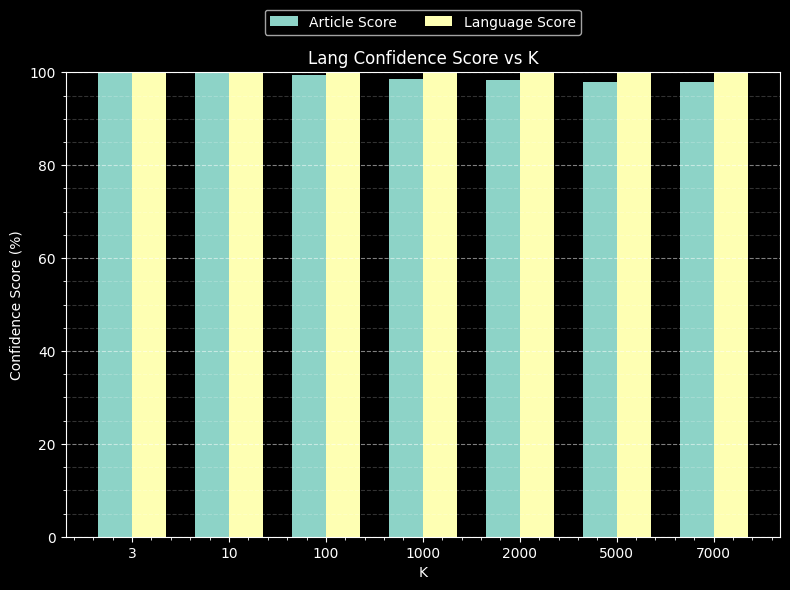

In [12]:
from matplotlib import pyplot as plt
from numpy import arange
from utils.text_utils import article_analysis, language_analysis

K: tuple = (3, 10, 100, 1000, 2000, 5000, 7000)
# K: tuple = (2, 3, 4, 5)
findings: dict[int, tuple] = dict()

for k in K:
    article_score = lang_confidence_score(article_analysis(k))
    language_data = lang_confidence_score(language_analysis(k))
    findings[k] = (article_score, language_data)

# przygotowanie danych
ks = list(findings.keys())
article_scores = [findings[k][0] for k in ks]
language_scores = [findings[k][1] for k in ks]

x = arange(len(ks))
width = 0.35

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# słupki
ax.bar(x - width / 2, article_scores, width, label="Article Score")
ax.bar(x + width / 2, language_scores, width, label="Language Score")

# osie i opisy
ax.set_xlabel("K")
ax.set_ylabel("Confidence Score (%)")
ax.set_title("Lang Confidence Score vs K")
ax.set_xticks(x)
ax.set_xticklabels(ks)
ax.set_ylim(0, 100)

# legenda nad wykresem
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.5)
ax.grid(True, which="minor", axis="y", linestyle="--", alpha=0.2)
ax.minorticks_on()

plt.tight_layout()
plt.show()


## Interpretacja wykresu *Lang Confidence Score vs K*

Wykres przedstawia porównanie dwóch miar dopasowania językowego w funkcji parametru **K** (liczby uwzględnianych słów):

- **Article Score** – obliczany dla słów wybranych i posortowanych według `wiki_freq`
- **Language Score** – obliczany dla słów wybranych i posortowanych według `rel_freq`

#### Obserwacje

- Dla małych wartości **K (3, 10)** oba wyniki są niskie, co wskazuje, że niewielka liczba słów nie wystarcza do wiarygodnej oceny języka.
- W przedziale **K ≈ 100–1000** następuje gwałtowny wzrost obu miar, co oznacza, że rdzeń językowy zaczyna być reprezentowany w sposób stabilny.
- Dla dużych **K (≥ 2000)** wyniki osiągają plateau w okolicach **75–80%**, co sugeruje nasycenie informacyjne – dodawanie kolejnych, rzadszych słów wnosi niewielką nową informację językową.

#### Relacja między słupkami

- **Language Score jest konsekwentnie wyższy niż Article Score** dla wszystkich wartości K.
- Oznacza to, że słowa najczęstsze w wiki  są statystycznie lepiej dopasowane do języka niż słowa wybrane wyłącznie na podstawie globalnej częstości.
- Wskazuje to na tematyczną spójność wiki: wiki używa charakterystycznych dla języka słów, ale w proporcjach przesuniętych względem ogólnego rozkładu językowego.


## Analiza dla wybranych wpisów do wiki

In [ ]:
# generate dictionaries for data/*.json

NON_WIKI_PL_RAW = "https://pl.wikipedia.org/wiki/Powszechna_deklaracja_praw_cz%C5%82owieka"
NON_WIKI_EN_RAW = "https://en.wikipedia.org/wiki/Universal_Declaration_of_Human_Rights"
NON_WIKI_DE_RAW = "https://de.wikipedia.org/wiki/Allgemeine_Erkl%C3%A4rung_der_Menschenrechte"

"""
using the scrapper find the WIKI_LONG and WIKI_SHORT_BAD articles and their dictionaries.

5 dictionaries to generate:
    "wiki_long": load_word_counts("data/wiki_long.json"),
    "wiki_short_bad": load_word_counts("data/wiki_short_bad.json"),
    "nonwiki_pl": load_word_counts("data/nonwiki_pl.json"),
    "nonwiki_en": load_word_counts("data/nonwiki_en.json"),
    "nonwiki_de": load_word_counts("data/nonwiki_de.json")

Additiionally generate 3 dictionaries:
    - with top common 1000 words from these 3 languages (pl, en, de)
"""




In [13]:
# Analiza skuteczności funkcji language_score
# =====================================

# --- 1. Importy ---
import json

# import math
# import pandas as pd
# import matplotlib.pyplot as plt
# from collections import Counter

# Opcjonalnie: wordfreq (jeżeli dostępne)
try:
    from wordfreq import top_n_list, zipf_frequency

    WORDFREQ_AVAILABLE = True
except ImportError:
    WORDFREQ_AVAILABLE = False


# --- 2. Definicja funkcji badanej ---
# Funkcja porównuje rozkład słów w tekście z rozkładem referencyjnym języka

def language_score(word_counts: dict[str, int],
                   lang_freqs: dict[str, float],
                   k: int) -> float:
    """
    word_counts: słownik {słowo: liczba_wystąpień} dla analizowanego tekstu
    lang_freqs: słownik {słowo: częstość} dla języka referencyjnego
    k: liczba najczęstszych słów języka użytych do porównania
    """
    # Normalizacja tekstu
    total_words = sum(word_counts.values())
    if total_words == 0:
        return 0.0

    text_freq = {w: c / total_words for w, c in word_counts.items()}

    score = 0.0
    for word, ref_freq in list(lang_freqs.items())[:k]:
        score += text_freq.get(word, 0.0) * ref_freq

    return score


# --- 3. Dane językowe (top-k słów) ---

def load_language_frequencies(lang: str, n: int = 1000) -> dict[str, float]:
    if not WORDFREQ_AVAILABLE:
        raise RuntimeError("Brak paczki wordfreq")

    words = top_n_list(lang, n)
    freqs = {w: 10 ** zipf_frequency(w, lang) for w in words}

    # normalizacja
    total = sum(freqs.values())
    return {w: f / total for w, f in freqs.items()}


languages = {
    "pl": None,
    "en": None,
    "de": None
}

for lang in languages:
    languages[lang] = load_language_frequencies(lang, 1000)


# --- 4. Wczytywanie word-counts.json ---

def load_word_counts(path: str) -> dict[str, int]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


# Przykładowa struktura danych testowych
# Użytkownik powinien podmienić ścieżki na własne
texts = {
    "wiki_long": load_word_counts("analysis/data/wiki_long.json"),
    "wiki_short_bad": load_word_counts("analysis/data/wiki_short_bad.json"),
    "nonwiki_pl": load_word_counts("analysis/data/nonwiki_pl.json"),
    "nonwiki_en": load_word_counts("analysis/data/nonwiki_en.json"),
    "nonwiki_de": load_word_counts("analysis/data/nonwiki_de.json")
}

# --- 5. Obliczenia ---
ks = [3, 10, 100, 1000]

results = []

for text_name, wc in texts.items():
    for lang, freqs in languages.items():
        for k in ks:
            score = language_score(wc, freqs, k)
            results.append({
                "text": text_name,
                "language": lang,
                "k": k,
                "score": score
            })

results_df = pd.DataFrame(results)
results_df

# --- 6. Wizualizacja ---
for k in ks:
    subset = results_df[results_df["k"] == k]
    pivot = subset.pivot(index="text", columns="language", values="score")

    pivot.plot(kind="bar", figsize=(10, 5))
    plt.title(f"Wyniki language_score dla k={k}")
    plt.ylabel("score")
    plt.xlabel("tekst")
    plt.tight_layout()
    plt.show()

# --- 7. Wnioski (do uzupełnienia ręcznie) ---
# - Zachowanie funkcji dla małych i dużych k
# - Separacja języka wiki od pozostałych
# - Stabilność względem długości tekstu


FileNotFoundError: [Errno 2] No such file or directory: 'data/wiki_long.json'